In [2]:
# VAE.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
in_channel=1
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
# 定义 VAE 编码器
class VAEEncoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super().__init__()
        self.conv1=nn.Conv2d(in_channel,16,kernel_size=3,stride=2,padding=1)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=7)
        self.flatten= nn.Flatten()
            #nn.Linear(in_features=64,out_features=2),
        self.fc1 = nn.Linear(64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size * 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x=torch.relu(self.conv2(x))
        x=torch.relu(self.conv3(x))
        x=self.flatten(x)
        #print(x.shape)
        #print(self.fc1)
        x=torch.relu(self.fc1(x))
        x = self.fc2(x)
        mu, log_var = x.split(latent_size, dim=1)
        return mu, log_var

# 定义 VAE 解码器
class VAEDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.reshape=Reshape((-1, 64, 1, 1))
        self.convTran1=nn.ConvTranspose2d(64,32,kernel_size=7)
        self.convTran2=nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.convTran3=nn.ConvTranspose2d(16,in_channel,kernel_size=3,stride=2,padding=1,output_padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x=self.reshape(x)
        x=torch.relu(self.convTran1(x))
        x=torch.relu(self.convTran2(x))
        x=torch.sigmoid(self.convTran3(x))
        return x


class Classify(nn.Module):
    def __init__(self, hidden_size, n_class=10):
        super().__init__()
        self.conv1=nn.Conv2d(in_channel,16,kernel_size=3,stride=2,padding=1)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=7)
        self.flatten= nn.Flatten()
            #nn.Linear(in_features=64,out_features=2),
        self.fc1 = nn.Linear(64, hidden_size)
        self.fc2 = nn.Linear(hidden_size,n_class)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x=torch.relu(self.conv2(x))
        x=torch.relu(self.conv3(x))
        x=self.flatten(x)
        x=torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x,dim=1)
    
# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self,hidden_size, latent_size):
        super().__init__()
        self.encoder = VAEEncoder(hidden_size, latent_size)
        self.decoder = VAEDecoder(latent_size, hidden_size)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        recon = self.decoder(z)
        return recon, mu, log_var

# 定义 VAE 损失函数
def vae_loss(recon, x, mu, log_var):
    #print(recon,x)
    recon_loss = nn.BCELoss(reduction='sum')(recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

# 加载 MNIST 数据集
transform = transforms.Compose([
    #transforms.Resize((28,28)),
    transforms.ToTensor(),
    #transforms.Normalize(0.5, 0.5,0.5)
])
mnist = datasets.MNIST(root='.', download=True, transform=transform)

# 定义训练参数
batch_size = 64
lr = 1e-3
num_epochs = 30

# 定义数据加载器
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True) # shuffle=True 打乱数据

# 定义模型、优化器和损失函数
# 定义 VAE 模型
input_size = 28*28
hidden_size = 256
latent_size = 64




In [3]:
import tqdm
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = VAE( hidden_size, latent_size)
model=model.to(device)
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=lr)
classify_model=Classify(hidden_size).to(device)
classify_optimizer=optim.Adam(classify_model.parameters(), lr=lr)
criterion=nn.CrossEntropyLoss()

# 训练 VAE 模型
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_loss1=0.0
    for x, labels in tqdm.tqdm(data_loader):
       # x = x.view(-1, input_size)
        #print(x)
        x=x.to(device)
        labels=labels.to(device)
        recon, mu, log_var = model(x)
        
        predict=classify_model(x)
        classify_loss=criterion(predict,labels)
        classify_optimizer.zero_grad()
        classify_loss.backward()
        classify_optimizer.step()
        
        loss = vae_loss(recon, x, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss1+=classify_loss.item()
    print(f'Epoch {epoch+1} loss: {epoch_loss / len(mnist):.4f} classicy_loss:{epoch_loss1 / len(mnist):.4f}' )             
    
# 保存模型
torch.save(model.state_dict(), 'vae.pth')
torch.save(classify_model.state_dict(),'classify.pth')

100%|██████████| 938/938 [00:13<00:00, 68.98it/s]


Epoch 1 loss: 201.9463 classicy_loss:0.0260


100%|██████████| 938/938 [00:12<00:00, 77.55it/s]


Epoch 2 loss: 158.9101 classicy_loss:0.0236


100%|██████████| 938/938 [00:12<00:00, 76.46it/s]


Epoch 3 loss: 143.0545 classicy_loss:0.0234


100%|██████████| 938/938 [00:12<00:00, 77.36it/s]


Epoch 4 loss: 134.1881 classicy_loss:0.0233


100%|██████████| 938/938 [00:12<00:00, 77.78it/s]


Epoch 5 loss: 130.0955 classicy_loss:0.0232


100%|██████████| 938/938 [00:12<00:00, 76.68it/s]


Epoch 6 loss: 126.3640 classicy_loss:0.0232


100%|██████████| 938/938 [00:12<00:00, 77.92it/s]


Epoch 7 loss: 123.3397 classicy_loss:0.0232


100%|██████████| 938/938 [00:12<00:00, 77.52it/s]


Epoch 8 loss: 120.8055 classicy_loss:0.0231


100%|██████████| 938/938 [00:12<00:00, 76.92it/s]


Epoch 9 loss: 118.4719 classicy_loss:0.0231


100%|██████████| 938/938 [00:12<00:00, 77.90it/s]


Epoch 10 loss: 116.9258 classicy_loss:0.0231


100%|██████████| 938/938 [00:12<00:00, 77.72it/s]


Epoch 11 loss: 115.8778 classicy_loss:0.0231


100%|██████████| 938/938 [00:12<00:00, 78.11it/s]


Epoch 12 loss: 115.0054 classicy_loss:0.0231


100%|██████████| 938/938 [00:11<00:00, 78.47it/s]


Epoch 13 loss: 114.2029 classicy_loss:0.0231


100%|██████████| 938/938 [00:12<00:00, 77.49it/s]


Epoch 14 loss: 113.4512 classicy_loss:0.0230


100%|██████████| 938/938 [00:11<00:00, 78.20it/s]


Epoch 15 loss: 112.7680 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.21it/s]


Epoch 16 loss: 112.1751 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.92it/s]


Epoch 17 loss: 111.4023 classicy_loss:0.0230


100%|██████████| 938/938 [00:11<00:00, 78.26it/s]


Epoch 18 loss: 110.6192 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.36it/s]


Epoch 19 loss: 110.0585 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.62it/s]


Epoch 20 loss: 109.6513 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.19it/s]


Epoch 21 loss: 109.2869 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.66it/s]


Epoch 22 loss: 108.9665 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.68it/s]


Epoch 23 loss: 108.6940 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 76.88it/s]


Epoch 24 loss: 108.3941 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.66it/s]


Epoch 25 loss: 108.1046 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.95it/s]


Epoch 26 loss: 107.7091 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 76.94it/s]


Epoch 27 loss: 107.3375 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.76it/s]


Epoch 28 loss: 107.1314 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.37it/s]


Epoch 29 loss: 107.0281 classicy_loss:0.0230


100%|██████████| 938/938 [00:12<00:00, 77.80it/s]

Epoch 30 loss: 106.7360 classicy_loss:0.0230


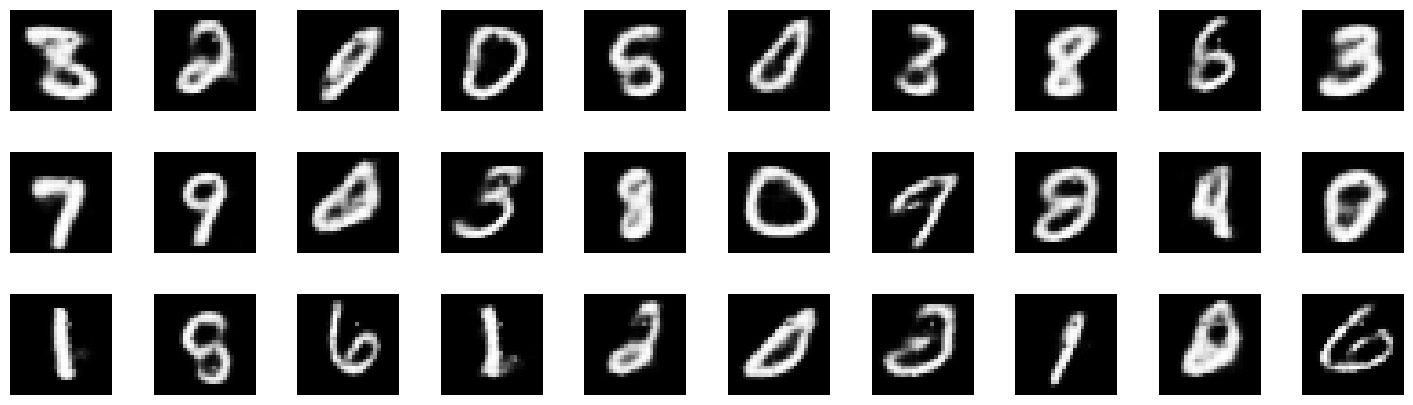

In [4]:
import numpy as np
n_to_show = 30

znew =torch.from_numpy( np.random.normal(size = (n_to_show,latent_size)))
model.eval()
recon = model.decoder(znew.float().cuda())

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    img = recon[i].squeeze()
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(img.detach().cpu().numpy(),cmap='gray')
    ax.axis('off')

plt.show()
fig.savefig('1.png')

## 开始实现vqgan-clip架构

In [86]:
import argparse
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.nn import functional as F
import kornia.augmentation as K
import numpy as np
from torchvision import transforms


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply



#数据增强
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow # not used with pooling
        
        # Pick your own augments & their order
        augment_list = []
        for item in args.augments[0]:
            if item == 'Ji':
                augment_list.append(K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7))
            elif item == 'Sh':
                augment_list.append(K.RandomSharpness(sharpness=0.3, p=0.5))
            elif item == 'Gn':
                augment_list.append(K.RandomGaussianNoise(mean=0.0, std=1., p=0.5))
            elif item == 'Pe':#
                augment_list.append(K.RandomPerspective(distortion_scale=0.7, p=0.7))
            elif item == 'Ro':
                augment_list.append(K.RandomRotation(degrees=15, p=0.7))
            elif item == 'Af':#
                augment_list.append(K.RandomAffine(degrees=15, translate=0.1, shear=5, p=0.7, padding_mode='zeros', keepdim=True)) # border, reflection, zeros
            elif item == 'Et':#
                augment_list.append(K.RandomElasticTransform(p=0.7))
            elif item == 'Ts':
                augment_list.append(K.RandomThinPlateSpline(scale=0.8, same_on_batch=True, p=0.7))
            elif item == 'Cr':
                augment_list.append(K.RandomCrop(size=(self.cut_size,self.cut_size), pad_if_needed=True, padding_mode='reflect', p=0.5))
            elif item == 'Er':#
                augment_list.append(K.RandomErasing(scale=(.1, .4), ratio=(.3, 1/.3), same_on_batch=True, p=0.7))
            elif item == 'Re':
                augment_list.append(K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5))
                
        self.augs = nn.Sequential(*augment_list)
        self.noise_fac = 0.1

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        cutouts = []
        
        ## 多个crop
        for _ in range(self.cutn):            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        
        ##增强
        batch = self.augs(torch.cat(cutouts, dim=0))
        ## 加噪
        if self.noise_fac:
            facs = batch.new_empty([self.cutn*input.shape[0], 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch



def make_grid(sample, sampling_number = 64,nrow=-1):
    if nrow==-1:
        row_number = int(math.sqrt(sampling_number))
        col_number = int(math.sqrt(sampling_number))
    else:
        row_number=nrow
        col_number=sampling_number //nrow
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    return show_sample

def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(6, 6))
    #clear_output()
    show_sample = make_grid(sample, sampling_number)

    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()
    
def load_model():
    model=VAE( hidden_size, latent_size)
    model.load_state_dict(torch.load('vae.pth'))
    model=model.to(device).eval().requires_grad_(False)
    return model

def load_perceptor():
    perceptor=Classify(hidden_size).to(device)
    perceptor.load_state_dict(torch.load('classify.pth'))
    perceptor=perceptor.eval().requires_grad_(False).to(device)
    return perceptor

def get_opt(z,opt_lr):
        return optim.Adam([z], lr=opt_lr)

def decode(model,z):
    img=model.decoder(z)
    imgs=torch.stack((img,)*3).view(-1,3,28,28)
    return imgs

def get_loss(model,perceptor,z,make_cutouts ,normalize,i):
    n=z.shape[0]
    out=decode(model,z)

    out=make_cutouts(out)
    predict=perceptor(out[:,:1])
    criterion=nn.CrossEntropyLoss()
    label=torch.LongTensor([args.prompts]*out.shape[0]).to(device)

    if i%50==0:
        with torch.inference_mode():
            out=model.decoder(z)
            imshow(out,n)
        print(torch.mean(criterion(predict,label)))

    return [torch.mean(criterion(predict,label))]


def train(model,perceptor,z,opt,epochs):
    cut_size = args.clip_input_size
    normalize = transforms.Normalize(mean=args.mean,std=args.std)
    make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
    for i in tqdm(range(epochs)):
        opt.zero_grad(set_to_none=True)
        lossAll = get_loss(model,perceptor,z,make_cutouts ,normalize,i)
        loss = sum(lossAll)
        loss.backward()
        opt.step()
        with torch.inference_mode():
            z.copy_(z.maximum(args.z_min).minimum(args.z_max))
    return z


In [61]:
device = torch.device('cuda:0')
class Trainer_Args():
    prompts=None
    max_iterations=100
    lr=0.02
    cutn=64
    cut_pow=1
    seed=0
    augments=[['Af','Pe', 'Et', 'Er','Gn']]
    cuda_device='cuda'
    clip_input_size=28
    z_min=torch.Tensor([-3.]).to(device)
    z_max=torch.Tensor([3]).to(device)
    mean=0.5
    std=0.5
args=Trainer_Args()

In [48]:
import os
import math
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
device=torch.device('cuda:0')
def generate(prompt,epochs=500):

    args.prompts=prompt
    args.iterations=epochs
    
    if not os.path.exists('steps'):
        os.mkdir('steps')

    model = load_model()
    perceptor=load_perceptor()
    
    cut_size = args.clip_input_size
    print('cut_size:',cut_size)

    n=4
    z=torch.Tensor(np.random.normal(size = (n,latent_size))).to(device)
    z_orig = z.clone()
    z.requires_grad_(True)
    opt = get_opt(z, args.lr)
    z=train(model,perceptor,z,opt,epochs)
    out=model.decoder(z)
    return out
     

print('done')



done


cut_size: 28


  0%|          | 0/800 [00:00<?, ?it/s]

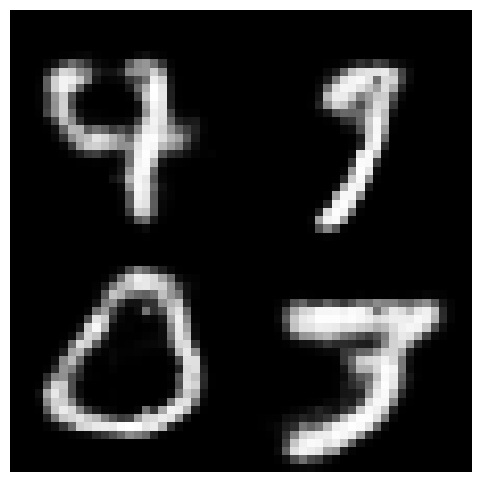

  0%|          | 1/800 [00:00<01:44,  7.65it/s]

tensor(2.3641, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 45/800 [00:02<00:38, 19.41it/s]


KeyboardInterrupt: 

In [73]:
prompt=0
generate(prompt,epochs=800)

In [62]:
from IPython.display import clear_output
results=[]
for prompt in range(10):
    print(prompt)
    results.append(generate(prompt,500))
    clear_output()
print('done')

done


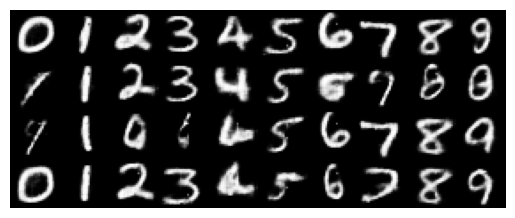

In [90]:
all_results=torch.cat(results,dim=0)
plt.figure()
show_sample = make_grid(all_results, 40,4)

plt.axis(False)
plt.imshow(show_sample, cmap = 'gray')
plt.savefig('1.png')
plt.show()